# Transfer Learning with PyTorch

We're going to take a pretrained model from `torchvision.models` and customize it to work on our classification problem. In the upcoming steps, we'll be dealing with the Weather_Dataset, addressing a multiclass classification task with four categories: 'Cloudy', 'Rain', 'Shine', and 'Sunrise'. We will follow the standard PyTorch workflow, which consists of the following steps:

| <span style="font-size:15px">**Step** | <span style="font-size:15px">**Description** |
| :-----| :----- |
| <span style="font-size:15px">**1. Data preprocessing** |<span style="font-size:14px"> Prepare your dataset to be processed by the model. |
| <span style="font-size:15px">**2. Getting a pretrained model** |<span style="font-size:14px"> Select a pretrained model and customize it to adapt it to the specific problem. | 
|<span style="font-size:15px"> **3. Fitting the model to data** |<span style="font-size:14px"> Select a loss function, optimizer and build a training loop.|
| <span style="font-size:15px">**4. Assessing the model performance** |<span style="font-size:14px">Compute relevant evaluation metrics based on the model's predictions and the ground truth labels.

# 0. Getting setup
### Importing necessary libraries and modules

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Model evaluation
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Basic libraries
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import numpy as np
import random
import pathlib
import os
import time
import copy

### Set device

Setup device-agnostic code for our models and data to run on GPU if it's available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Data preprocessing

To prepare the data, we'll follow the same procedures detailed in section 2, which include defining the required transformations, setting up datasets, and configuring dataloaders.
>**Important**: When utilizing a pretrained model, it is crucial to ensure that your custom data is prepared in the same manner as the original training data. This consistency will help achieve optimal performance and accurate predictions.

[PyTorch documentation](https://pytorch.org/vision/0.8/models.html#torchvision-models) informs that all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224 (Some pretrained models need different sizes, so, for specific input image sizes, see the documentation). The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

> **Note about the mean and standard deviation values:**
> These values are calculated from the entire dataset or a representative subset of it during the data preprocessing phase. Specifically, the values mentioned above were obtained from an Imagenet subset. While it is true that neural networks are usually capable of figuring out appropriate data distributions on their own, setting the mean and standard deviation values at the start can help our networks achieve better performance more quickly.

We can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| :----- | :----- | :----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224. | `torchvision.transforms.Resize()` or `torchvision.transforms.CenterCrop()` to resize images into `[3, 224, 224]` and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` and standard deviation of `[0.229, 0.224, 0.225]`(values across each colour channel). | `torchvision.transforms.Normalize(mean =..., std =...)` to adjust the mean and standard deviation of our images.  |

In [3]:
# Define the transformation steps using transforms.Compose()
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.2),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
]),
    'val': transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])
}

In [4]:
# Define the data_dir
data_dir = '../datasets/Weather_Dataset_Split'
splits = ['train', 'val']

# Create the datasets using ImageFolder class
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 8, shuffle = True) for x in splits}

# Calculate the sizes of the different datasets and obtain the class names
dataset_sizes = {x: len(image_datasets[x]) for x in splits}
class_names = image_datasets['train'].classes

# Print the information
print("Dataset Sizes:", dataset_sizes)
print("Class Names:", class_names)

Dataset Sizes: {'train': 809, 'val': 146}
Class Names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


# 2. Getting a pretrained model

In [5]:
# Load a ResNet-18 model with weights pretrained on the ImageNet dataset
model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1')

# Replace the FC layer with a classifier that has 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to the specified device (GPU/CPU) for computation
model = model.to(DEVICE)

# 3. Fitting the model to data

## 3.1 Build a training loop

In [6]:
def train_model(model, criterion, optimizer,model_path,num_epochs = 20):

    since = time.time()
    best_acc = 0.0
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Update results dictionary
            if phase == 'train':
                results["train_loss"].append(epoch_loss)
                results["train_acc"].append(epoch_acc)

            
            elif phase == 'val':
                results["val_loss"].append(epoch_loss)
                results["val_acc"].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(model_path))
                print('Model saved!')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Return the filled results at the end of the epochs
    return results

## 3.2 Define the loss function and configure the optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001)

## 3.3 Train the model

In [9]:
MODEL_PATH = '../data/models/resnet18_TL_WeatherDataset.pth'
model_TL_results = train_model(model, criterion, optimizer, MODEL_PATH, num_epochs = 5)

Epoch 0/4
----------
train Loss: 1.0966 Acc: 0.5674
val Loss: 0.6848 Acc: 0.8630
Model saved!

Epoch 1/4
----------
train Loss: 0.6521 Acc: 0.8393
val Loss: 0.3814 Acc: 0.9178
Model saved!

Epoch 2/4
----------
train Loss: 0.4114 Acc: 0.9061
val Loss: 0.2849 Acc: 0.9384
Model saved!

Epoch 3/4
----------
train Loss: 0.3360 Acc: 0.9110
val Loss: 0.2118 Acc: 0.9452
Model saved!

Epoch 4/4
----------
train Loss: 0.2877 Acc: 0.9221
val Loss: 0.1862 Acc: 0.9452

Training complete in 1m 7s
Best val Acc: 0.945205


### Plot loss and accuracy evolution over time

In [11]:
def plot_curves(results: Dict[str, List[float]]):
    
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and validation)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']
    
    # Convert tensors to CPU before plotting
    accuracy = [x.item() for x in accuracy]
    val_accuracy = [x.item() for x in val_accuracy]

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'train_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'train_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

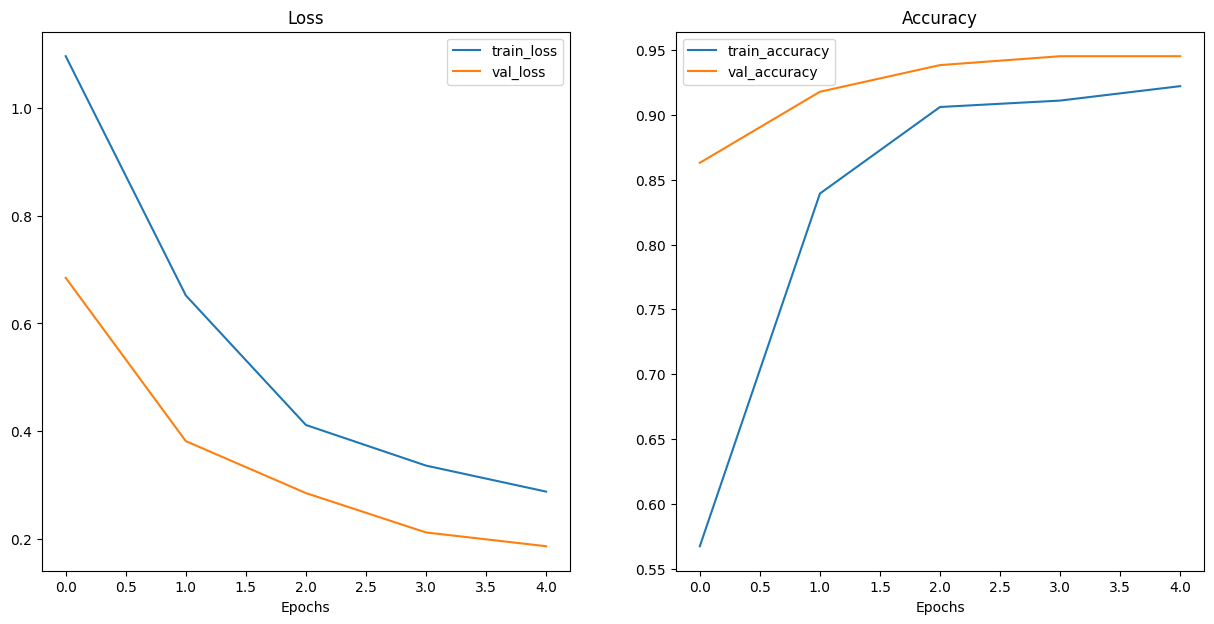

In [12]:
plot_curves(model_TL_results)

# 4. Assessing the model performance

## 4.1 Prepare the test dataset

In [13]:
# Define the transformation steps using transforms.Compose()
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])

# Define the data_dir
data_dir = '../datasets/Weather_Dataset_Split'

# Create the datasets using ImageFolder class
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transforms) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True) 

# Print the dataset size
print("Test dataset :", len(test_dataset))

Test dataset : 170


## 4.2 Load your trained model

The model trained in this notebook can be loaded from the directory:

```
data/ 
    models/ 
        resnet18_TL_WeatherDataset.pth
```

In [14]:
# Load a ResNet-18 model architecture
model = torchvision.models.resnet18()

# Replace the FC layer with a classifier that has 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to the specified device
model.to(DEVICE)

# Load trained weights
MODEL_PATH = '../data/models/resnet18_TL_WeatherDataset.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

## 4.3 Build a testing loop

In [15]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for test_data in test_dataloader: # Iterate over the test dataloader to get test images and labels
        test_images, test_labels = (test_data[0].to(DEVICE), 
                                    test_data[1].to(DEVICE))
        # Forward pass through the model to get predictions
        output = model(test_images)
        
        # Compute the predicted labels by taking the argmax of the softmax output
        pred_label = torch.softmax(output, dim = 1).argmax(dim = 1)

        # Append the true labels and predicted labels to their respective lists
        y_true.append(test_labels.cpu())
        y_pred.append(pred_label.cpu())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

## 4.4 Compute metrics

### Classification report

In [16]:
# Generate the classification report and print it
report = classification_report(y_true, 
                               y_pred, 
                               target_names = ["Cloudy", "Rain", "Shine","Sunrise"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

      Cloudy     0.9535    0.9111    0.9318        45
        Rain     1.0000    1.0000    1.0000        33
       Shine     0.8780    0.9474    0.9114        38
     Sunrise     0.9811    0.9630    0.9720        54

    accuracy                         0.9529       170
   macro avg     0.9532    0.9554    0.9538       170
weighted avg     0.9544    0.9529    0.9532       170



### Confusion matrix

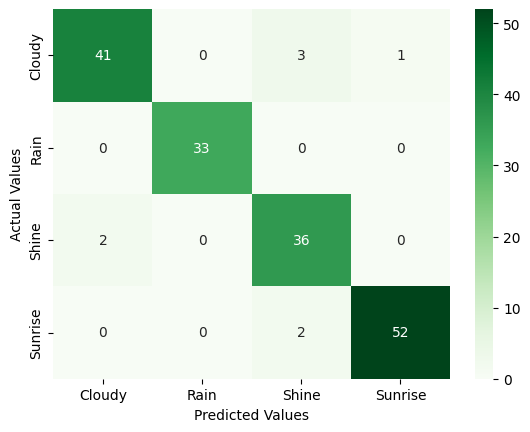

In [17]:
# Generate the confusion matrix
cmat = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix visualization
ax = sns.heatmap(cmat, annot = True, cmap = 'Greens')

# Set labels for x-axis and y-axis
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set the labels 
ax.xaxis.set_ticklabels(['Cloudy', 'Rain', 'Shine','Sunrise'])
ax.yaxis.set_ticklabels(['Cloudy', 'Rain', 'Shine','Sunrise'])

# Display the visualization of the Confusion Matrix
plt.show()

The model demonstrates outstanding performance in classifying the four categories. Employing transfer learning leads to a significant improvement in the model's performance compared to training it from scratch. This enhancement is attributed to utilizing a neural network architecture (ResNet-18) that has proven its effectiveness in handling similar problems, enabling us to capture more intricate patterns beyond the capabilities of the simple neural network constructed previously

## 4.5 Visualize model predictions on images from the test set

The model's quantitative performance appears satisfactory, but now it's time to assess its qualitative capabilities. To do this, u se the trained model to make predictions on on images from the test set and visualize the predicted class labels along with the images.

In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [23]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}| True label: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

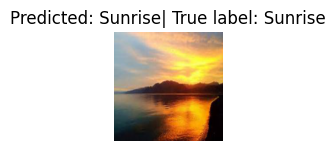

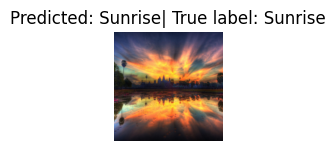

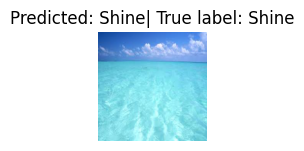

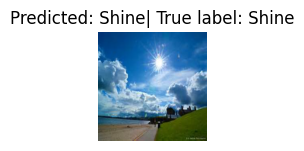

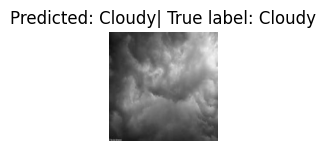

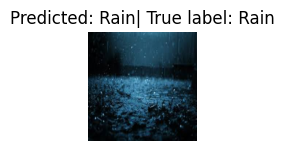

In [26]:
visualize_model(model, num_images = 6)

# EXERCISES

Repeat the process from notebooks 3 and 4 (classification using the Weather_dataset) but this time, use a network previously trained on ImageNet. Apply the feature extraction approach by freezing all layers of the model that are not part of the classifier. Finally, obtain and compare the results on the test dataset with those obtained from our baseline model.